In [1]:
from google.colab import drive

drive.mount('/content/drive', force_remount=True)

# 输入daseCV所在的路径
# 'daseCV' 文件夹包括 '.py', 'classifiers' 和'datasets'文件夹
# 例如 'CV/assignments/assignment1/daseCV/'
FOLDERNAME = '/content/drive/MyDrive/assignment1/daseCV'

assert FOLDERNAME is not None, "[!] Enter the foldername."

%cd drive/My\ Drive
%cp -r $FOLDERNAME ../../
%cd ../../
%cd daseCV/datasets/
!bash get_datasets.sh
%cd ../../

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.activity.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fexperimentsandconfigs%20https%3a%2f%2fwww.googleapis.com%2fauth%2fphotos.native&response_type=code

Enter your authorization code:
4/1AX4XfWi2wPPT9CbPQtHGvsbR5x3M1te9M0JwAu1i02tDh4iEk-cpYohPTpM
Mounted at /content/drive
/content/drive/My Drive
/content
/content/daseCV/datasets
--2021-10-17 02:32:14--  http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to ww

# Softmax 练习

*补充并完成本练习。*

本练习类似于SVM练习，你要完成的事情包括:

- 为Softmax分类器实现完全矢量化的**损失函数**
- 实现其**解析梯度（analytic gradient）**的完全矢量化表达式
- 用数值梯度**检查你的代码**
- 使用验证集**调整学习率和正则化强度**
- 使用**SGD优化**损失函数
- **可视化**最终学习的权重


In [2]:
import random
import numpy as np
from daseCV.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [3]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'daseCV/datasets/cifar-10-batches-py'
    
    # Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
    try:
       del X_train, y_train
       del X_test, y_test
       print('Clear previously loaded data.')
    except:
       pass

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Softmax 分类器

请在**daseCV/classifiers/softmax.py**中完成本节的代码。

In [6]:
# 首先使用嵌套循环实现简单的softmax损失函数。
# 打开文件 daseCV/classifiers/softmax.py 并补充完成
# softmax_loss_naive 函数.

from daseCV.classifiers.softmax import softmax_loss_naive
import time

# 生成一个随机的softmax权重矩阵，并使用它来计算损失。
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

loss: 2.305535
sanity check: 2.302585


**问题 1**


为什么我们期望损失接近-log（0.1）？简要说明。

$\color{blue}{\textit 答:}$ 因为有十个类，期望的损失为0.1



In [7]:
# 完成softmax_loss_naive，并实现使用嵌套循环的梯度的版本(naive)。
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# 就像SVM那样，请使用数值梯度检查作为调试工具。
# 数值梯度应接近分析梯度。
from daseCV.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# 与SVM情况类似，使用正则化进行另一个梯度检查
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: -0.092313 analytic: -0.092313, relative error: 7.848583e-07
numerical: 1.186202 analytic: 1.186202, relative error: 2.666723e-09
numerical: -1.058982 analytic: -1.058982, relative error: 4.874924e-09
numerical: 1.913691 analytic: 1.913691, relative error: 1.297657e-08
numerical: -1.460689 analytic: -1.460689, relative error: 8.856265e-09
numerical: 3.023018 analytic: 3.023018, relative error: 2.030259e-08
numerical: -0.421117 analytic: -0.421117, relative error: 2.074646e-07
numerical: 1.896211 analytic: 1.896211, relative error: 5.072040e-09
numerical: -0.908376 analytic: -0.908376, relative error: 1.670384e-08
numerical: 0.220471 analytic: 0.220470, relative error: 2.823862e-07
numerical: -0.416161 analytic: -0.416162, relative error: 2.992578e-07
numerical: 2.751280 analytic: 2.751280, relative error: 7.537741e-09
numerical: -0.374107 analytic: -0.374107, relative error: 8.300424e-08
numerical: 1.934267 analytic: 1.934267, relative error: 8.725618e-09
numerical: -0.606299

In [8]:
# 现在，我们有了softmax损失函数及其梯度的简单实现，
# 接下来要在 softmax_loss_vectorized 中完成一个向量化版本.
# 这两个版本应计算出相同的结果，但矢量化版本应更快。
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from daseCV.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# 正如前面在SVM练习中所做的一样，我们使用Frobenius范数比较两个版本梯度。
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 2.305535e+00 computed in 0.221637s
vectorized loss: 2.305535e+00 computed in 0.023503s
Loss difference: 0.000000
Gradient difference: 0.000000


In [10]:
# 使用验证集调整超参数（正则化强度和学习率）。您应该尝试不同的学习率和正则化强度范围; 
# 如果您小心的话，您应该能够在验证集上获得超过0.35的精度。
from daseCV.classifiers import Softmax
results = {}
best_val = -1
best_softmax = None
learning_rates = [1e-7, 5e-7]
regularization_strengths = [2.5e4, 5e4]

################################################################################
# 需要完成的事:                                                                        
# 对验证集设置学习率和正则化强度。
# 这与之前SVM中做的类似；
# 保存训练效果最好的softmax分类器到best_softmax中。
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
for lr in learning_rates:
    for reg in regularization_strengths:
        softmax = Softmax()
        loss_hist = softmax.train(X_train, y_train, learning_rate=lr, reg=reg,
                      num_iters=1500, verbose=True)
        y_train_pred = softmax.predict(X_train)
        y_val_pred = softmax.predict(X_val)
        y_train_acc = np.mean(y_train_pred==y_train)
        y_val_acc = np.mean(y_val_pred==y_val)
        results[(lr,reg)] = [y_train_acc, y_val_acc]
        if y_val_acc > best_val:
            best_val = y_val_acc
            best_softmax = softmax
# pass

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

iteration 0 / 1500: loss 387.887396
iteration 100 / 1500: loss 234.265144
iteration 200 / 1500: loss 142.444479
iteration 300 / 1500: loss 86.723143
iteration 400 / 1500: loss 53.350264
iteration 500 / 1500: loss 33.032353
iteration 600 / 1500: loss 20.762014
iteration 700 / 1500: loss 13.331908
iteration 800 / 1500: loss 8.807347
iteration 900 / 1500: loss 6.143814
iteration 1000 / 1500: loss 4.560600
iteration 1100 / 1500: loss 3.519878
iteration 1200 / 1500: loss 2.984078
iteration 1300 / 1500: loss 2.527354
iteration 1400 / 1500: loss 2.365570
iteration 0 / 1500: loss 778.842106
iteration 100 / 1500: loss 285.855298
iteration 200 / 1500: loss 105.761081
iteration 300 / 1500: loss 40.045934
iteration 400 / 1500: loss 15.935950
iteration 500 / 1500: loss 7.161054
iteration 600 / 1500: loss 3.967596
iteration 700 / 1500: loss 2.663295
iteration 800 / 1500: loss 2.321994
iteration 900 / 1500: loss 2.161244
iteration 1000 / 1500: loss 2.106063
iteration 1100 / 1500: loss 2.187975
iterat

In [11]:
# 在测试集上评估
# 在测试集上评估最好的softmax
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.360000


**问题 2** - *对或错*

假设总训练损失定义为所有训练样本中每个数据点损失的总和。可能会有新的数据点添加到训练集中，同时SVM损失保持不变，但是对于Softmax分类器的损失而言，情况并非如此。

$\color{blue}{\textit 你的回答:}$正确


$\color{blue}{\textit 你的解释:}$对于softmax分类器，当增加新的数据点时，正确类别和错误类别输出分数差距越大，损失函数越小。



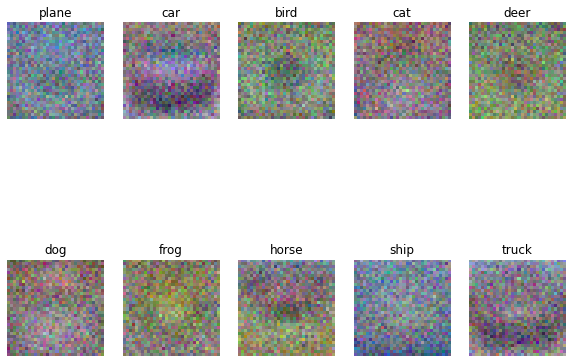

In [12]:
# 可视化每个类别的学习到的权重
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
    
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])

---
# 重要

防止作业被吞

这里是作业的结尾处，请执行以下步骤:

1. 点击`File -> Save`或者用`control+s`组合键，确保你最新的的notebook的作业已经保存到谷歌云。
2. 执行以下代码确保 `.py` 文件保存回你的谷歌云。

In [14]:
import os

FOLDER_TO_SAVE = os.path.join('drive/My Drive/', FOLDERNAME)
FILES_TO_SAVE = ['daseCV/classifiers/softmax.py']

for files in FILES_TO_SAVE:
  with open(os.path.join(FOLDER_TO_SAVE, '/'.join(files.split('/')[1:])), 'w') as f:
    f.write(''.join(open(files).readlines()))